<a href="https://colab.research.google.com/github/lqh52/Early-prediction-of-sepsis/blob/main/Cox_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
!pip install lifelines
from lifelines import CoxPHFitter

     |████████████████████████████████| 358kB 3.8MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=ce718195e4cfc8e4e18455a4bc4e49849591e08fce5f09d345c4d1a3770a758a
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
train = pd.read_pickle('/content/drive/MyDrive/Sepsis_predict/train.pkl')
test = pd.read_pickle('/content/drive/MyDrive/Sepsis_predict/test.pkl')

In [ ]:
train.drop('SepsisLabel', axis=1, inplace=True)

In [ ]:
cph = CoxPHFitter()
cph.fit(train, duration_col='time_to_sepsis', event_col='sepsis_occur')

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1090: ConvergenceWarning: Column(s) ['FiO2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column sofa_det have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['sepsis_occur'].astype(bool)
>>> print(df.loc[events, 'sofa_det'].var())
>>> print(df.loc[~events, 'sofa_det'].var())

A very low variance means that the column sofa_det completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regress

<lifelines.CoxPHFitter: fitted with 1.24502e+06 total observations, 1.21332e+06 right-censored observations>

In [ ]:
TrueLabel = test['SepsisLabel']
test.drop(['SepsisLabel', 'time_to_sepsis', 'sepsis_occur'], axis=1, inplace=True)

In [ ]:
PredictLabel =  (1-cph.predict_survival_function(test,0))

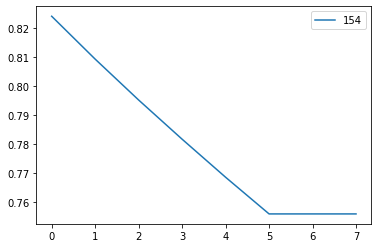

In [ ]:
import matplotlib.pyplot as plt

cph.predict_survival_function(test.iloc[0,:]).plot()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt
def roc(predictions, true):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = np.linspace(np.min(predictions), np.max(predictions), 50)
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)

    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)
    
    #calculate the AUC
    AUC = auc(results['fpr'].values, results['tpr'].values)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC\nAUC=%.2f' % AUC)
    plt.tight_layout()
    plt.show()

    results = results.sort_values(by='acc', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh

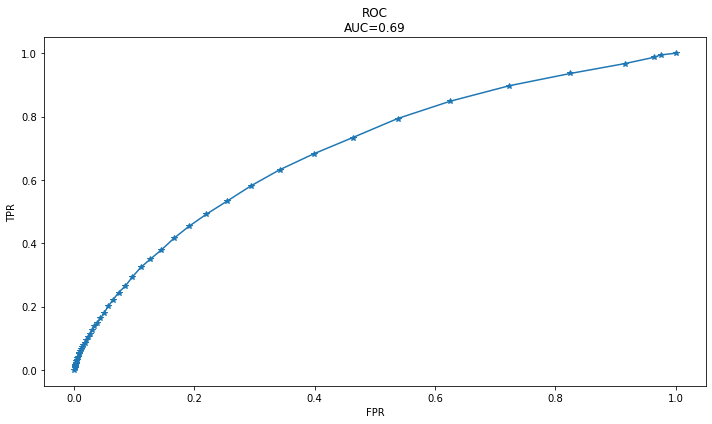

In [ ]:
results_df, thresh_final = roc(np.array(PredictLabel).flatten(), np.array(TrueLabel).flatten())
results_df = results_df.sort_values(by='fpr')

In [ ]:
PredictLabel = np.array(PredictLabel).transpose()
TrueLabel = np.array(TrueLabel)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(TrueLabel, PredictLabel)

In [ ]:
gmeans = np.sqrt(tpr.T * (1-fpr.T)) #balance between the sensitivity and the specificity

In [ ]:
ix = np.argmax(gmeans)

In [ ]:
final_threshold = thresholds[ix]
final_threshold

0.20378227866388965

In [ ]:
input = pd.read_pickle('//content/drive/MyDrive/Sepsis_predict/Pickle_input/input_final.pkl')
input['HCO3'] = train['HCO3'].mean()
input['BaseExcess'] = train['BaseExcess'].mean()
input

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,HospAdmTime,SepsisLabel,patient,qsofa,sofa,SIRS,ShockIndex,BUN/CR,mews,sofa_det,sepsis_occur,time_to_sepsis
0,0.41250,0.957895,0.424,0.577099,0.177990,0.297436,0.375000,0.767857,0.238776,0.441939,0.0,0.503030,0.410000,0.056626,0.065186,0.847826,0.766082,0.191326,0.105583,0.773988,0.0,0.244970,0.406779,0.950000,0.66875,0.664286,0.229191,1.0,0.153465,0.135135,1.0,0.375839,0.794798,0.067695,0.485294,1.0,0.000000,0.327615,0.0,100008.0,0.0,0.000000,0.0,0.187567,0.274201,0.0,0.0,0,7
1,0.40000,0.940789,0.200,0.366412,0.129187,0.243590,0.416667,0.714286,0.238776,0.441939,0.0,0.503030,0.410000,0.056626,0.065186,0.791304,0.766082,0.361586,0.105583,0.687283,0.0,0.144970,0.406779,0.950000,0.66875,0.671429,0.229191,1.0,0.153465,0.135135,1.0,0.375839,0.794798,0.067695,0.485294,1.0,0.000000,0.327615,0.0,100008.0,0.0,0.000000,0.0,0.318000,0.303138,0.2,0.0,0,7
2,0.46250,0.986842,0.160,0.458015,0.153110,0.294872,0.416667,0.767857,0.238776,0.441939,0.0,0.503030,0.410000,0.056626,0.065186,0.791304,0.766082,0.388352,0.105583,0.687283,0.0,0.127219,0.406779,0.950000,0.66875,0.685714,0.229191,1.0,0.153465,0.135135,1.0,0.375839,0.794798,0.067695,0.485294,1.0,0.000000,0.327615,0.0,100008.0,0.0,0.000000,0.0,0.294526,0.303138,0.2,0.0,0,7
3,0.53750,0.960526,0.140,0.217557,0.093301,0.198718,0.562500,0.928571,0.238776,0.441939,0.0,0.503030,0.410000,0.056626,0.065186,0.717391,0.766082,0.838910,0.105583,0.523121,0.0,0.103550,0.406779,1.000000,0.40000,0.750000,0.229191,1.0,0.410891,0.378378,1.0,0.436242,0.794798,0.123393,0.485294,1.0,0.000000,0.327615,0.0,100008.0,0.0,0.857143,0.0,0.585071,0.407849,0.2,1.0,0,7
4,0.58125,0.973684,0.140,0.106870,0.078947,0.198718,0.708333,1.000000,0.238776,0.441939,0.0,0.000000,1.000000,0.056626,0.065186,0.791304,0.766082,0.004957,0.000000,0.687283,0.0,0.079882,0.545838,0.950000,0.66875,0.607143,0.229191,1.0,0.153465,0.135135,1.0,0.375839,0.794798,0.067695,0.485294,1.0,0.000000,0.327615,0.0,100008.0,1.0,0.142857,1.0,0.796154,0.303138,0.6,0.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.56250,0.963158,0.336,0.458015,0.253589,0.512821,0.458333,0.657319,0.238776,0.441939,1.0,0.572638,0.549883,0.056626,0.065186,0.108696,0.766082,0.993804,1.000000,0.161850,0.0,0.063905,1.000000,0.708333,0.45000,0.107143,0.229191,1.0,0.940594,0.940541,1.0,0.100671,0.794798,0.627249,0.191176,1.0,0.495799,0.941066,0.0,100172.0,0.0,0.000000,0.0,0.364599,0.078582,0.2,0.0,0,7
391,0.53750,0.960526,0.320,0.297710,0.191388,0.384615,0.583333,0.657319,0.238776,0.441939,1.0,0.572638,0.549883,0.056626,0.065186,0.108696,0.766082,0.993804,1.000000,0.161850,0.0,0.063905,1.000000,0.708333,0.45000,0.107143,0.229191,1.0,0.940594,0.940541,1.0,0.100671,0.794798,0.627249,0.191176,1.0,0.495799,0.941066,0.0,100172.0,0.0,0.000000,0.0,0.491379,0.078582,0.2,0.0,0,7
392,0.55000,0.960526,0.392,0.541985,0.291866,0.576923,0.750000,0.657319,0.238776,0.441939,1.0,0.572638,0.549883,0.056626,0.065186,0.108696,0.766082,0.993804,1.000000,0.161850,0.0,0.124260,1.000000,0.708333,0.45000,0.107143,0.229191,1.0,0.940594,0.940541,1.0,0.100671,0.794798,0.627249,0.191176,1.0,0.495799,0.941066,0.0,100172.0,0.5,0.000000,1.0,0.295946,0.078582,0.4,0.0,0,7
393,0.43750,0.986842,0.336,0.396947,0.244019,0.538462,0.583333,0.657319,0.238776,0.441939,1.0,0.572638,0.549883,0.056626,0.065186,0.108696,0.766082,0.993804,1.000000,0.161850,0.0,0.063905,1.000000,0.708333,0.45000,0.107143,0.229191,1.0,0.940594,0.940541,1.0,0.100671,0.794798,0.627249,0.191176,1.0,0.495799,0.941066,0.0,100172.0,0.0,0.000000,0.0,0.322093,0.078582,0.2,0.0,0,7


In [ ]:
input_patient = input.groupby('patient')
save_count = 0
for patient, group in input_patient:
  df = pd.DataFrame()
  df['PredictedProbability'] = pd.Series(np.array(1-cph.predict_survival_function(group,0)).reshape(len(group,)))
  df['PredictedLabel'] = (df['PredictedProbability'] > final_threshold).astype(int)
  print(df)
  filename = '/content/drive/MyDrive/Sepsis_predict/Output/'+'p'+str(patient)+'.psv'
  df.to_csv(filename,sep='|')
  save_count += 1